In [38]:
ls ../input/rsna-breast-cancer-detection/train_images | head -1 -n 4

10006/
10011/
10025/
10038/
ls: write error


In [39]:
ls ../input/rsna-breast-cancer-detection/train_images/57175

1084689895.dcm  110562898.dcm  1564996746.dcm  269811751.dcm


In [41]:
import pandas as pd
from matplotlib import pyplot as plt

sample_sub = pd.read_csv('../input/rsna-breast-cancer-detection/sample_submission.csv')

In [42]:
sample_sub

,prediction_id,cancer
0,10008_L,0.021168
1,10008_R,0.021168


In [43]:
!ls -l ../input/rsna-breast-cancer-detection/train_images | wc -l # wc -l outputs one a count of one row too many when used like this! hence we need to subtract one to get the true count

11914


In [44]:
ls ../input/rsna-breast-cancer-detection/test_images/10008

1591370361.dcm  361203119.dcm  68070693.dcm  736471439.dcm


In [45]:
import pydicom
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import glob

In [46]:
example = '../input/rsna-breast-cancer-detection/train_images/10006/1459541791.dcm'
pydicom.dcmread(example)

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '183901.792591'
(0010, 0020) Patient ID                          LO: '10006'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.10006
(0020, 000e) Series Instance

In [48]:
# source: https://www.kaggle.com/code/allunia/rsna-csf-cervical-spine-fracture-eda/notebook
def rescale_img_to_hu(dcm_ds):
    """Rescales the image to Hounsfield unit."""
    data = dcm_ds.pixel_array
    if dcm_ds.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    return data * dcm_ds.RescaleSlope + dcm_ds.RescaleIntercept

In [49]:
def show_images_for_patient(patient_id):
    patient_dir = os.path.join('../input/rsna-breast-cancer-detection/train_images', str(patient_id))
    num_images = len(glob.glob(f"{patient_dir}/*"))
    print(f"Number of images for patient: {num_images}")
    fig, axs = plt.subplots(2, 2, figsize=(24,15))
    axs = axs.flatten()
    for i, img_path in enumerate(list(Path(patient_dir).iterdir())):
        ds = pydicom.dcmread(img_path)
        axs[i].imshow(rescale_img_to_hu(ds), cmap="bone")

Number of images for patient: 4


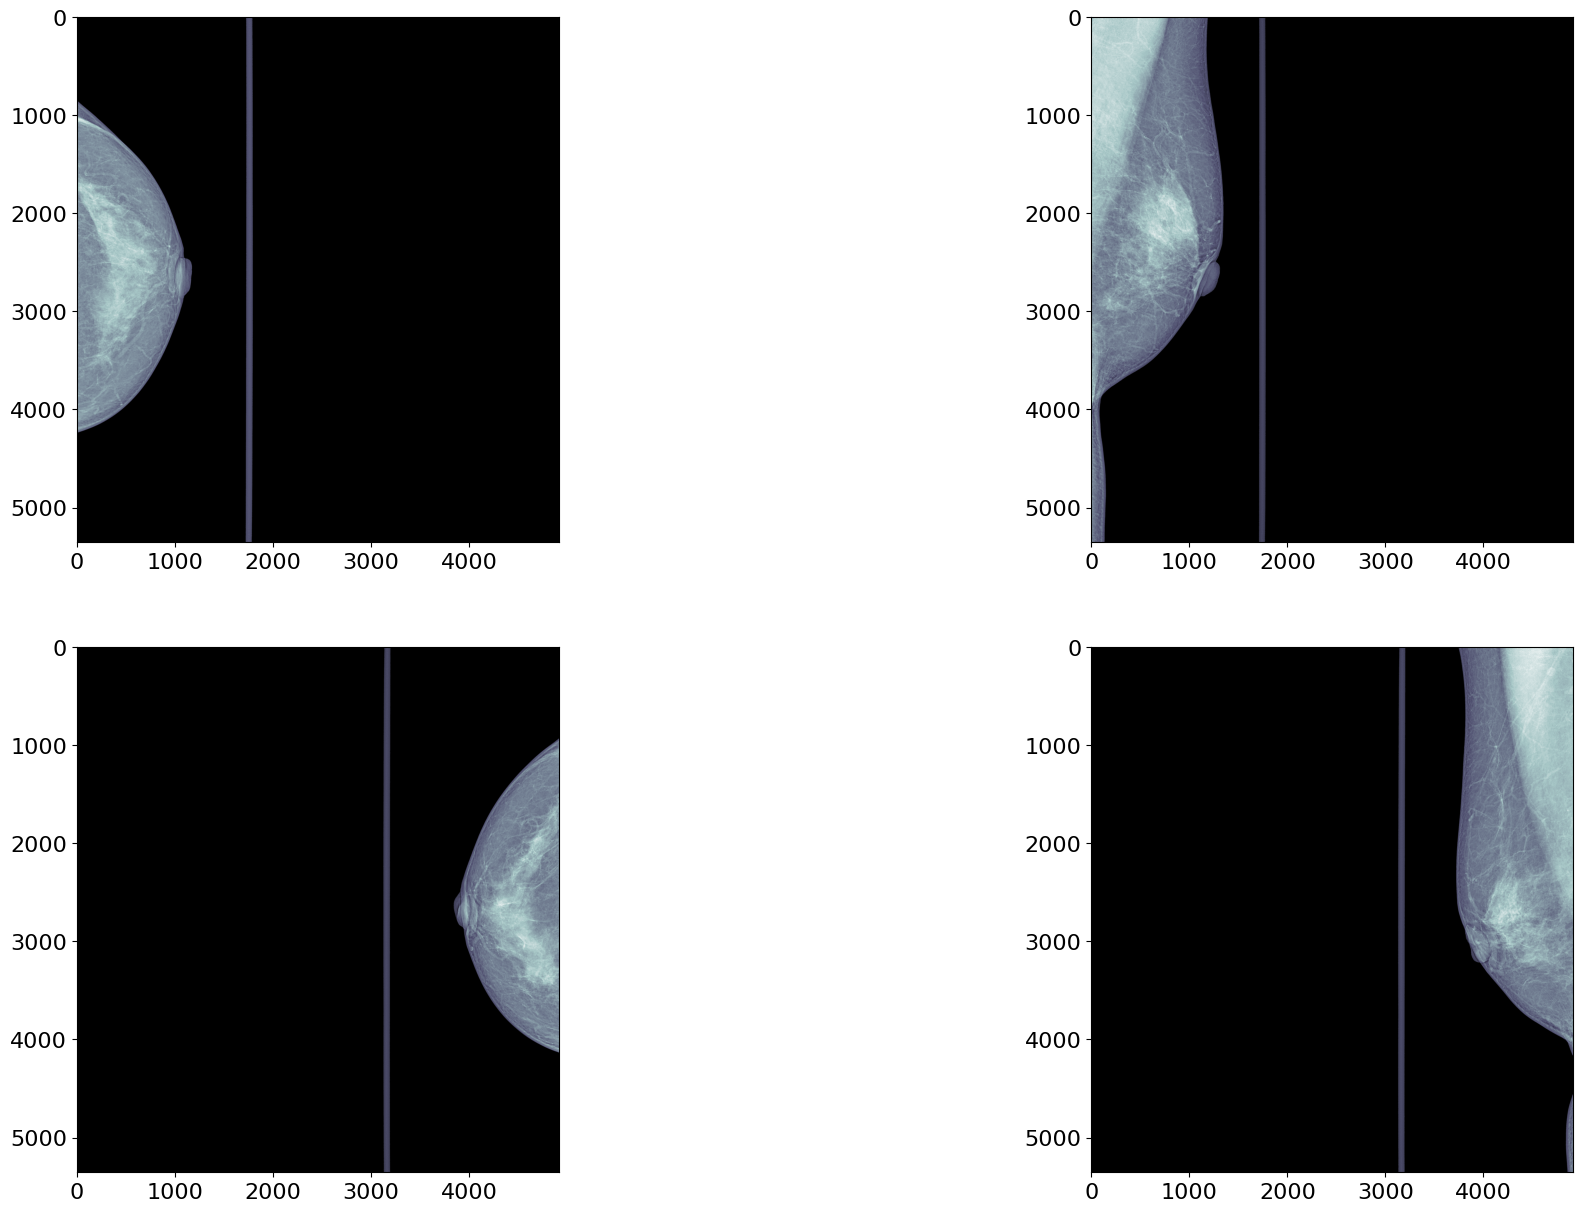

In [50]:
show_images_for_patient(10006)

In [51]:
train_csv = pd.read_csv('../input/rsna-breast-cancer-detection/train.csv')
train_csv.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [52]:
test_csv = pd.read_csv('../input/rsna-breast-cancer-detection/test.csv')
test_csv

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [53]:
train_csv.shape[0], train_csv.patient_id.nunique()

(54706, 11913)

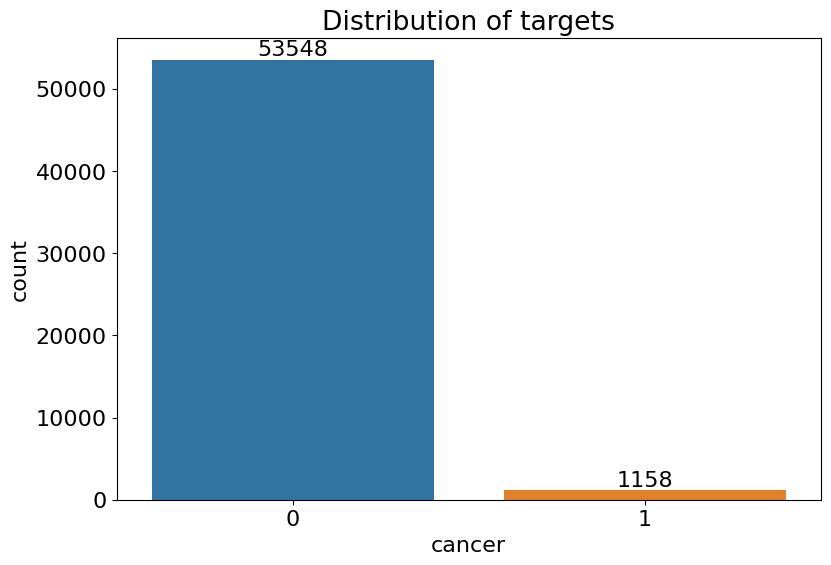

In [54]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
ax1 = sns.countplot(data=train_csv, x='cancer')
for container in ax1.containers:
    ax1.bar_label(container)
plt.title('Distribution of targets');

In [55]:
from fastai.data.all import *
from fastai.vision.all import *

path = '../input/rsna-mammography-images-as-pngs/images_as_pngs/train_images_processed'

train_csv = pd.read_csv('../input/rsna-breast-cancer-detection/train.csv')
fn2label = {fn: cancer_or_not for fn, cancer_or_not in zip(train_csv['image_id'].astype('str'), train_csv['cancer'])}

def label_func(path):
    return fn2label[path.stem]

dblock = DataBlock(
    blocks    = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = label_func,
    splitter  = RandomSplitter()
)
dsets = dblock.datasets(path)
dls = dblock.dataloaders(path)

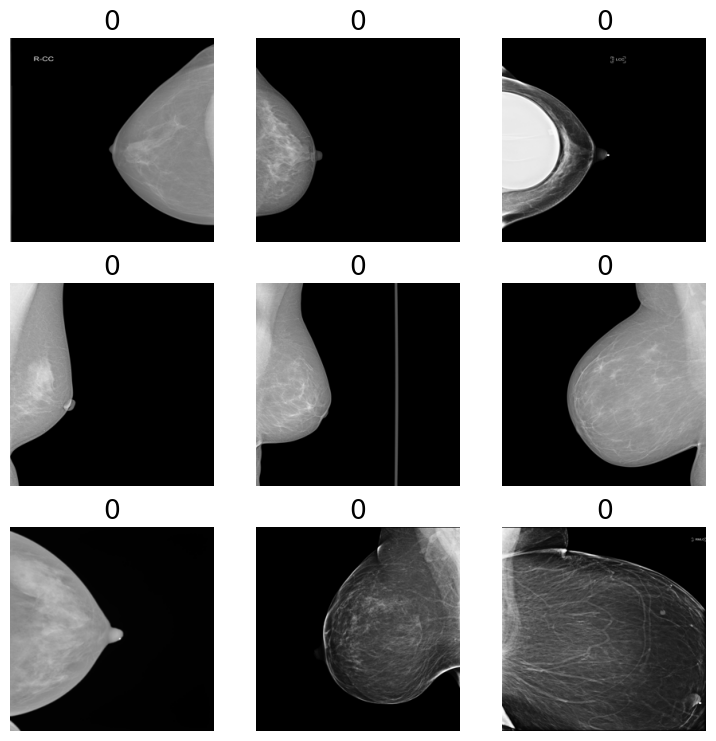

In [56]:
dls.show_batch()


In [57]:
learn = vision_learner(dls, resnet18, metrics=error_rate, pretrained=False)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.120288,0.095726,0.019011,02:23


In [58]:
ls ../input/rsna-breast-cancer-detection/test_images

10008/


In [59]:
submission = pd.DataFrame(data={'prediction_id': test_csv['prediction_id'], 'cancer': np.random.rand(test_csv.shape[0])}).drop_duplicates(subset='prediction_id')
submission.head()

,prediction_id,cancer
0,10008_L,0.229957
2,10008_R,0.665525
